# 프로젝트: 고양이 수염 스티커 만들기

## Step 1. 스티커 구하기 or 만들기
- [고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)

1. 고양이 이미지 다운로드
2. 셀카 이미지 촬영

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

`dlib`을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

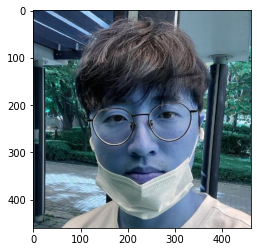

In [2]:
import os

my_image_path = os.path.dirname(os.path.abspath('__file__')) + r'/camera_sticker/images/selfie.jpeg'

img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지 읽기
# img_bgr = cv2.resize(img_bgr, (800, 1200))
img_show = img_bgr.copy() # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

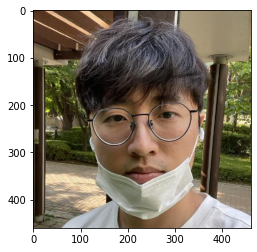

In [3]:
# RGB로 출력
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)

- 2, 36, 48, 30 번 인덱스를 이용

In [4]:
import dlib

detector_hog = dlib.get_frontal_face_detector() # detector 선언

In [5]:
# detector를 이용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(117, 167) (340, 390)]]


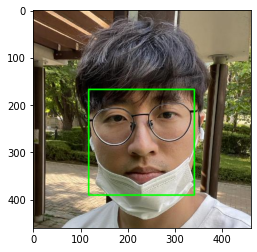

In [6]:
# 찾은 얼굴을 화면에 출력
print(dlib_rects) # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
# 저장한 landmark 모델 불러오기
import os

model_path = os.path.dirname(os.path.abspath('__file__')) + r'/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


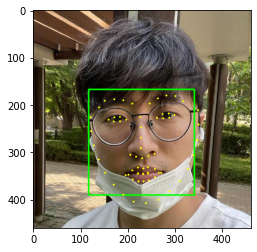

In [9]:
# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 4. 스티커 적용하기
1. `np.where` 를 사용해서 스티커를 적용
2. 스티커 뒤로 원본 이미지가 같이 보이도록 만들기

**고양이 스티커의 위치**
$$x=x_{nose}$$
$$y=y_{nose}$$

**스티커의 크기**
$$width=height$$

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 좌표
    # 랜드마크에서 코의 좌표
    x = landmark[33][0]
    y = landmark[33][1]
    
    # 얼굴 폭과 높이
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print(f"코의 중심점 위치: ({x}, {y})")
    print(f"얼굴 랜드마크 크기: ({w}, {h})")

(230, 312)
코의 중심점 위치: (230, 312)
얼굴 랜드마크 크기: (224, 224)


(224, 224, 3)


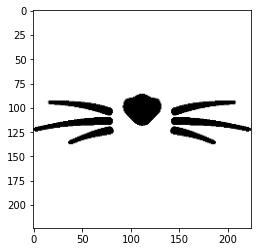

In [11]:
# 스티커 이미지 출력
import os

sticker_path = os.path.dirname(os.path.abspath('__file__')) + r'/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커의 크기를 얼굴 랜드마크 크기로 resize
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [12]:
# 스티커 시작 위치
refined_x = x - int(w / 2)
refined_y = y - int(h / 2)

print(f"이미지에서 스티커 좌표(top-left): ({refined_x}, {refined_y})")

이미지에서 스티커 좌표(top-left): (118, 200)


(224, 224, 3)


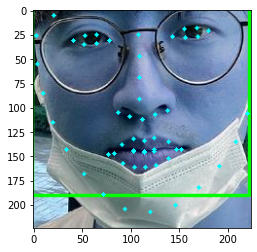

In [13]:
# 스티커 범위(sticker_area)
sticker_area = img_show[refined_y : refined_y + img_sticker.shape[0],
                        refined_x : refined_x + img_sticker.shape[1]]
print(sticker_area.shape)
plt.imshow(sticker_area)

In [14]:
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8) # True->스티커, False->sticker_area

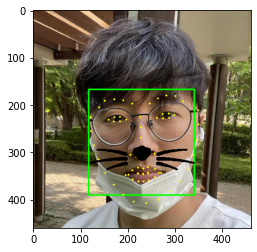

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

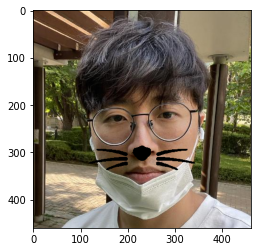

In [16]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기

1. 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복 적용
2. 문제점이 무엇인지 최대한 자세하게 기록하기. 생각한 문제점을 해결하기 위한 방법은 분명히 존재한다.

**스티커 앱에서 문제점**
- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요? => vector
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

# 평가
1. 원본에 스티커 사진이 정상적으로 합성이 되었다.
2. 정확한 좌표 계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 얼굴각도, 이미지 밝기, 촬영 거리 등 다양한 변수에 따른 영향들을 보고서에 체계적으로 분석하였다.

# 회고